In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
import gym
import numpy as np
import random
import tensorflow as tf
from tqdm import tqdm_notebook as tqdm
import pandas as pd
import pandas_profiling as pdp

In [17]:
# モデルの読み込み
env = gym.make("FrozenLake-v0")

In [18]:
# tenorflowの初期化
tf.reset_default_graph

<function tensorflow.python.framework.ops.reset_default_graph>

In [19]:
with tf.name_scope("model"):
    inputs1 = tf.placeholder(shape=[1, 16], dtype=tf.float32, name="input")
    
    with tf.variable_scope("Weight"):
        W = tf.Variable(tf.random_uniform([16, 4], 0, 0.01), name="W")
        tf.summary.histogram("W", W)

    # Q値の予測値
    Qout = tf.matmul(inputs1, W)
    # Q値の予測値が最大のactionを返す
    predict = tf.argmax(Qout, 1)

    # 最終的なQ値
    nextQ = tf.placeholder(shape=[1, 4], dtype=tf.float32, name="nextQ")

    with tf.name_scope("loss"):
        # nextQとQoutの差を最小化するようにWを更新する
        loss = tf.reduce_sum(tf.square(nextQ - Qout))
        
    with tf.name_scope("update"):
        # 最適化
        updateModel = tf.train.GradientDescentOptimizer(learning_rate=0.1).minimize(loss)

In [20]:
W

<tf.Variable 'model_1/Weight/W:0' shape=(16, 4) dtype=float32_ref>

In [21]:
predict

<tf.Tensor 'model_1/ArgMax:0' shape=(1,) dtype=int64>

In [22]:
updateModel

<tf.Operation 'model_1/update/GradientDescent' type=NoOp>

In [23]:
# ハイパーパラメータの設定
y = 0.99
e = 0.1
num_episodes = 2000

In [24]:
# 試行回数のリスト
jList = []
# 報酬のリスト
rList = []
# イプシロン（exploreの閾値）のリスト
eList = []

In [33]:
rewards_list = []

with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    merged = tf.summary.merge_all()
    writer = tf.summary.FileWriter("./logs", sess.graph)
    for i in tqdm(range(num_episodes)):
        # statusの初期化
        s = env.reset()
        # 報酬の累積和の初期化
        rAll = 0
        d = False
        j = 0
        while j < 99:
            j += 1
            # 前回のstatusからQ値を予測
            # a: Q値の最大値の手
            # allQ: Q値のリスト
            a, allQ = sess.run(
                [predict, Qout], feed_dict={inputs1: np.identity(16)[s : s + 1]}
            )

            # εグリーディー(ランダムな手を打たせる）
            # 10%以下の確率でランダムに指し手を決める
            if np.random.rand(1) < e:
                a[0] = env.action_space.sample()

            # actionを渡すと結果を返す
            # s1: 次のstate, r: 報酬, d: True/False, _: other
            s1, r, d, _ = env.step(a[0])

            # 次のQ値の推定値を求める
            Q1 = sess.run(Qout, feed_dict={inputs1: np.identity(16)[s1 : s1 + 1]})
            # 最大のQ値
            maxQ1 = np.max(Q1)
            # Q値のリスト
            targetQ = allQ

            # Q値のターゲットを更新する, ベルマン方程式
            targetQ[0, a[0]] = r + y * maxQ1

            # 新しい重みを求める
            _, W1, _merged = sess.run(
                [updateModel, W, merged],
                feed_dict={inputs1: np.identity(16)[s : s + 1], nextQ: targetQ},
            )

            # 報酬の累積和の更新
            rAll += r
            # stateの更新
            s = s1
            if d == True:
                # イプシロン（exploreの閾値）を更新
                e = 1.0 / ((i / 50) + 10)
                eList.append(e)
                
                # 報酬リストの更新
                rewards_list.append((i, rAll))
                break

        # 新しい重みを求める
        writer.add_summary(_merged)
        writer.flush()
        jList.append(j)  # 試行回数のリスト
        rList.append(rAll)  # 報酬のリスト

    writer.close()

print("Success Episode Ratio: {}%".format(sum(rList) / num_episodes * 100))

HBox(children=(IntProgress(value=0, max=2000), HTML(value='')))


Success Episode Ratio: 95.35%


In [26]:
%matplotlib inline

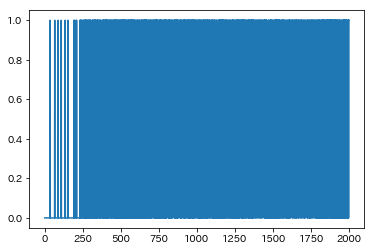

In [27]:
plt.plot(rList)

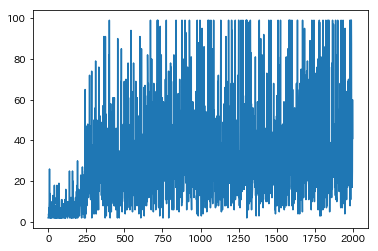

In [28]:
plt.plot(jList)

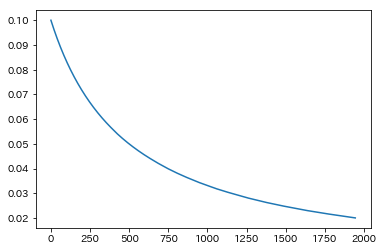

In [29]:
plt.plot(eList)

In [46]:
len(rewards_list)

1944

In [56]:
"""トレーニングの結果を可視化しよう"""
%matplotlib inline
import matplotlib.pyplot as plt

# 移動平均
def running_mean(x, N):
    # 累積和を求める
    cumsum = np.cumsum(np.insert(x,0,0))
    return (cumsum[N:] - cumsum[:-N]) / N

1945
[0.05 0.05 0.05 ... 0.75 0.75 0.7 ]


Text(0,0.5,'Total Rewards')

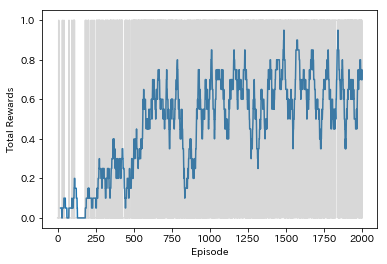

In [58]:
# [(エピソード番号, 報酬和), (),,,] -> [(エピソード番号, #, #, #), (報酬和, #, #, #)]に変換する
eps, rews = np.array(rewards_list).T
# 移動平均
smoothed_rews = running_mean(rews, 20)
# エピソード番号と移動平均
plt.plot(eps[-len(smoothed_rews) :], smoothed_rews)
# エピソード番号と報酬和
plt.plot(eps, rews, color="grey", alpha=0.3)
plt.xlabel("Episode")
plt.ylabel("Total Rewards")